Training a Multilayer Perceptron (MLP) model to identify hand-written digits

Adapted from: 

https://github.com/FluxML/model-zoo/tree/master/vision/mlp_mnist​

https://github.com/FluxML/model-zoo/tree/master?tab=readme-ov-file#examples-in-the-model-zoo​

https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi

Check Kernel status

In [1]:
versioninfo()

using Pkg
Pkg.status()

Julia Version 1.11.4
Commit 8561cc3d68d (2025-03-10 11:36 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 64 × Intel(R) Xeon(R) Gold 6338 CPU @ 2.00GHz
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, icelake-server)
Threads: 1 default, 0 interactive, 1 GC (on 64 virtual cores)
Environment:
  LD_LIBRARY_PATH = /.singularity.d/libs
Status `/projects/e33102/giannini_projects/my_ml_ds_project/Project.toml`
  [336ed68f] CSV v0.10.15
  [8f4d0f93] Conda v1.10.3
  [a93c6f00] DataFrames v1.8.1
  [587475ba] Flux v0.16.5
  [7073ff75] IJulia v1.33.0
  [a09fc81d] ImageCore v0.10.5
  [916415d5] Images v0.26.2
  [eb30cadb] MLDatasets v0.7.18
  [91a5bcdd] Plots v1.41.2
  [10745b16] Statistics v1.11.1
  [f3b207a7] StatsPlots v0.15.8


Import the necessary packages (this should be relatively quick if your Kernel is setup correctly)

In [2]:
using Pkg, Flux, MLDatasets, Statistics, ImageCore, Images

Define the model! It consists of the inputs, one hidden layer, and the output layer.

In [3]:
# Our model is very simple: Its one "hidden layer" has 32 "neurons" each connected to every input pixel.
# Each has a sigmoid nonlinearity, and is connected to every "neuron" in the output layer.
# Finally, softmax produces probabilities, i.e. positive numbers which add up to 1:

## Notice the sizes of things: square images going into 32 neurons
## then to the output layer, which is the probability that an input
## maps to a certain digit
model = Chain(Dense(28^2 => 32, sigmoid), Dense(32 => 10), softmax)

p1 = model(rand(Float32, 28^2))  # run model on random data shaped like an image

display("One random `image`")
@show p1
@show sum(p1) ≈1;

p3 = model(rand(Float32, 28^2, 3))  # ...or on a batch of 3 fake, random "images"

display("Three random `images`")
@show p3
@show sum(p3; dims=1);  # all approx 1. Last dim is batch dim.

"One random `image`"

p1 = Float32[0.11384831, 0.24061865, 0.048409823, 0.03886313, 0.048015535, 0.07053146, 0.108113386, 0.06289347, 0.14809272, 0.12061359]
sum(p1) ≈ 1 = true


"Three random `images`"

p3 = Float32[0.1272199 0.13273345 0.12927161; 0.2062281 0.23750305 0.19690678; 0.036225725 0.048242822 0.04262962; 0.031628583 0.03170951 0.041456893; 0.052721415 0.04210999 0.043034114; 0.08017606 0.05631794 0.07465381; 0.13172448 0.09362291 0.1286978; 0.07344808 0.08502384 0.068680204; 0.15737233 0.14971969 0.14368542; 0.1032553 0.123016834 0.13098373]
sum(p3; dims = 1) = Float32[0.9999999 1.0 1.0]


Load in the MNIST data - it will ask for verification that you want to download the dataset

Note: one-hot and one-cold encoding are used below - more information here : https://fluxml.ai/Flux.jl/previews/PR1612/data/onehot/

In [4]:
#===== DATA =====#

# Calling MLDatasets.MNIST() will dowload the dataset if necessary,
# and return a struct containing it.
# It takes a few seconds to read from disk each time, so do this once:

train_data = MLDatasets.MNIST()  # i.e. split=:train
test_data = MLDatasets.MNIST(split=:test)

# train_data.features is a 28×28×60000 Array{Float32, 3} of the images.
# We need a 2D array for our model. Let's combine the reshape needed with
# other pre-processing, in a function:

function simple_loader(data::MNIST; batchsize::Int=64)
    x2dim = reshape(data.features, 28^2, :)
    yhot = Flux.onehotbatch(data.targets, 0:9)
    Flux.DataLoader((x2dim, yhot); batchsize, shuffle=true)
end

# train_data.targets is a 60000-element Vector{Int}, of labels from 0 to 9.
# Flux.onehotbatch([0,1,9], 0:9) makes a matrix of 0 and 1.

# Load the training data
simple_loader(train_data)  # returns a DataLoader, with first element a tuple like this:

x1, y1 = first(simple_loader(train_data)); # (784×64 Matrix{Float32}, 10×64 OneHotMatrix)

model(x1)  # x1 is the right shape for our model

@show size(y1)  # y1 is the same shape as the model output.

## Calculating the loss function on the untrained model
@show Flux.crossentropy(model(x1), y1);  # This will be our loss function



size(y1) = (10, 64)
Flux.crossentropy(model(x1), y1) = 2.3745465f0


What does the (training) data look like?

(784, 64)
Bool[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


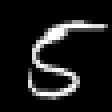

In [5]:
println(size(x1))

show_ind = 5

println(y1[:,show_ind])

reshape(x1[:,show_ind], 28, 28) .|> Gray |> transpose


Define a function to determine the accuracy of the model

In [6]:
#===== ACCURACY =====#

# We're going to log accuracy and loss during training. There's no advantage to
# calculating these on minibatches, since MNIST is small enough to do it at once.

function simple_accuracy(model, data::MNIST=test_data)
    (x, y) = only(simple_loader(data; batchsize=length(data)))  # make one big batch
    y_hat = model(x)
    iscorrect = Flux.onecold(y_hat) .== Flux.onecold(y)  # BitVector
    acc = round(100 * mean(iscorrect); digits=2)
end

@show simple_accuracy(model);  # accuracy about 10%, on training data, before training!

simple_accuracy(model) = 10.22


Train the model on the dataset

In [7]:
#===== TRAINING =====#

# Make a dataloader using the desired batchsize:

train_loader = simple_loader(train_data, batchsize = 256)

# Initialise storage needed for the Adam optimiser, with our chosen learning rate:

opt_state = Flux.setup(Adam(3e-4), model);

# Then train for 30 epochs, printing out details as we go:

for epoch in 1:30
    loss = 0.0
    for (x, y) in train_loader
        # Compute the loss and the gradients:
        l, gs = Flux.withgradient(m -> Flux.crossentropy(m(x), y), model)
        # Update the model parameters (and the Adam momenta):
        Flux.update!(opt_state, model, gs[1])
        # Accumulate the mean loss, just for logging:
        loss += l / length(train_loader)
    end

    if mod(epoch, 2) == 1
        # Report on train and test, only every 2nd epoch:
        train_acc = simple_accuracy(model, train_data)
        test_acc = simple_accuracy(model, test_data)
        @info "After epoch = $epoch" loss train_acc test_acc
    end
end

# This should get to about 94% accuracy.
# To do better, try using Dense(784 => 64, relu) instead.


┌ Info: After epoch = 1
│   loss = 1.7962251217104495
│   train_acc = 77.54
└   test_acc = 78.72
┌ Info: After epoch = 3
│   loss = 0.8487927527166903
│   train_acc = 86.33
└   test_acc = 87.08
┌ Info: After epoch = 5
│   loss = 0.5604151941370219
│   train_acc = 88.71
└   test_acc = 89.15
┌ Info: After epoch = 7
│   loss = 0.4378153826110065
│   train_acc = 90.08
└   test_acc = 90.38
┌ Info: After epoch = 9
│   loss = 0.37216216267552227
│   train_acc = 90.92
└   test_acc = 90.99
┌ Info: After epoch = 11
│   loss = 0.3310932883177884
│   train_acc = 91.56
└   test_acc = 91.6
┌ Info: After epoch = 13
│   loss = 0.3021705992287025
│   train_acc = 92.06
└   test_acc = 91.98
┌ Info: After epoch = 15
│   loss = 0.2802765005035326
│   train_acc = 92.52
└   test_acc = 92.39
┌ Info: After epoch = 17
│   loss = 0.26226279634283856
│   train_acc = 92.92
└   test_acc = 92.9
┌ Info: After epoch = 19
│   loss = 0.24816967773949727
│   train_acc = 93.23
└   test_acc = 93.1
┌ Info: After epoch = 21


Inspect the results of the training (for one number)!

In [8]:
#===== INSPECTION =====#

using ImageCore #, ImageInTerminal

## Load test data
xtest, ytest = only(simple_loader(test_data, batchsize=length(test_data)));


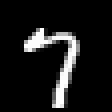

In [9]:
# There are many ways to look at images, you won't need ImageInTerminal if working in a notebook.
# ImageCore.Gray is a special type, which interprets numbers between 0.0 and 1.0 as shades:

show_ind = 76

reshape(xtest[:,show_ind], 28, 28) .|> Gray |> transpose


In [10]:
@show Flux.onecold(ytest, 0:9)[show_ind];  # true label, should match!

# Now we can compare the model's probabilities, for the same input.
# This should be highest at the same number:

p10 = (0:9) .=> model(xtest[:, show_ind]);
display(p10)

(Flux.onecold(ytest, 0:9))[show_ind] = 7


10-element Vector{Pair{Int64, Float32}}:
 0 => 0.00012466902
 1 => 4.335348f-5
 2 => 9.4073526f-5
 3 => 0.00023066279
 4 => 0.00022496501
 5 => 0.00019592926
 6 => 6.22241f-6
 7 => 0.9856059
 8 => 0.00015634687
 9 => 0.013317847

In [11]:
using ImageCore

# Get test data
xtest, ytest = only(simple_loader(test_data, batchsize=length(test_data)))
println("size of test dataset : ", size(xtest))

# Compute model predictions for the entire test set
predictions = model(xtest)
println("size of output predictions : ", size(predictions))



size of test dataset : (784, 10000)
size of output predictions : (10, 10000)


Exercise!

For this set of test data inputs and prediction outputs, find the sample that has the least confident overall classification. Print a table of the predictions for that sample and plot the image.

Hints:

1) Find the maximum predicted probabilities for each sample

2) Identify the index of the sample with the least confident classification

3) Extract/slice the least confident image, its true label, and the set of predictions for it

4) Display the least confident image

5) Print the list of predictions and the true label



In [12]:
## your answer here